For running in NoteBook

In [ ]:
!pip3 install transformers
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForCausalLM , AutoModel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 17.5 MB/s 
     |████████████████████████████████| 7.6 MB 63.3 MB/s 
     |████████████████████████████████| 163 kB 57.8 MB/s 


In [ ]:
# install transformes
!pip uninstall -y transformers
!pip install -q git+https://github.com/huggingface/transformers.git

# install py3nvml to track GPU memory usage
!pip install -q py3nvml

!rm -f run_benchmark.py
!rm -f run_benchmark_tf.py
!rm -f plot_csv_file.py
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/pytorch/benchmarking/run_benchmark.py -qq
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/pytorch/benchmarking/run_benchmark_tf.py -qq
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/pytorch/benchmarking/plot_csv_file.py -qq

# import pandas to pretty print csv files
import pandas as pd


!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/pytorch/language-modeling/run_clm.py
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/pytorch/language-modeling/run_mlm.py
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/pytorch/language-modeling/requirements.txt

!pip install -r requirements.txt



Found existing installation: transformers 4.24.0
Uninstalling transformers-4.24.0:
  Successfully uninstalled transformers-4.24.0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 55 kB 3.5 MB/s 
--2022-11-09 05:53:49--  https://raw.githubusercontent.com/huggingface/transformers/master/examples/pytorch/language-modeling/run_clm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25330 (25K) [text/plain]
Saving to: ‘run_clm.py’

run_clm.py          100%[===================>]  24.74K  --.-KB/s    in 0s      

2022-11-09 05:53:49 (109 MB/s) - ‘run_clm.py’ saved [25330/25330]

--2022-11-09 05:53:49--  https://raw.githubusercontent.com/huggingface/tr

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.save_pretrained("./models/gpt2-tokenizer/")

model_bert = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")
model_gpt2 = AutoModelForCausalLM.from_pretrained("gpt2")

model_gpt2.config.pad_token_id = tokenizer.pad_token_id

model_bart = AutoModel.from_pretrained("facebook/bart-base")

model_bert.save_pretrained('/content/models/bert')
model_gpt2.save_pretrained('/content/models/gpt2')
model_bart.save_pretrained('/content/models/bart')


Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Using pad_token, but it is not set yet.


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:

def pruning(model,layer_name, amount):
  parameters_to_prune = []

  for name, module in model.named_modules():
        if isinstance(module, layer_name):
            parameters_to_prune.append((module, 'weight'))
  prune.global_unstructured(
      parameters_to_prune,
      pruning_method=prune.L1Unstructured,
      amount=amount,
  )

  return model


def print_sparisity(model,layer_name):
  sparisity = 0.0
  nelement = 0.0
  for name, module in model.named_modules():
    if isinstance(module, layer_name):
      sparisity += torch.sum(module.weight == 0)
      nelement += module.weight.nelement()

  print(
    "Global sparsity: {:.2f}%".format(
        100. * float( sparisity
        )
        / float( nelement
        )
    )
)

layer_type = [torch.nn.modules.linear.Linear,transformers.pytorch_utils.Conv1D]
models = {'bert': (AutoModelForMaskedLM.from_pretrained("models/bert"), layer_type[0]), 'gpt-2':(AutoModelForCausalLM.from_pretrained("models/gpt2"), layer_type[1]), 'bart':(AutoModel.from_pretrained("models/bart"),layer_type[0])}
model_names = []

for key in models.keys():
  print('Starting pruning {}'.format(key))
  model = models[key][0]
  layer = models[key][1]
  for sparsity in [0.1, 0.5, 0.9, 0.95, 0.99]:
    pruned_model = pruning(model,layer,sparsity)
    if key == 'gpt-2':
      pruned_model.config.pad_token_id = tokenizer.pad_token_id
    print_sparisity(pruned_model,layer)
    pruned_model.save_pretrained('/content/models/{}-{}'.format(key,sparsity))
    model_names.append('/content/models/{}-{}'.format(key,sparsity))
    print('The size of the model {}-{} is: {}'.format(key,sparsity,pruned_model.num_parameters()))

Starting pruning bert
Global sparsity: 10.00%
The size of the model bert-0.1 is: 109514298
Global sparsity: 55.00%
The size of the model bert-0.5 is: 109514298
Global sparsity: 95.50%
The size of the model bert-0.9 is: 109514298
Global sparsity: 99.77%
The size of the model bert-0.95 is: 109514298
Global sparsity: 100.00%
The size of the model bert-0.99 is: 109514298
Starting pruning gpt-2
Global sparsity: 10.00%
The size of the model gpt-2-0.1 is: 124439808
Global sparsity: 55.00%
The size of the model gpt-2-0.5 is: 124439808
Global sparsity: 95.50%
The size of the model gpt-2-0.9 is: 124439808
Global sparsity: 99.77%
The size of the model gpt-2-0.95 is: 124439808
Global sparsity: 100.00%
The size of the model gpt-2-0.99 is: 124439808
Starting pruning bart
Global sparsity: 10.00%
The size of the model bart-0.1 is: 139420416
Global sparsity: 55.00%
The size of the model bart-0.5 is: 139420416
Global sparsity: 95.50%
The size of the model bart-0.9 is: 139420416
Global sparsity: 99.78%
T

bert
tensor([-0.0102, -0.0615, -0.0265,  ..., -0.0799,  0.1652,  0.3868],
       grad_fn=<CatBackward0>)


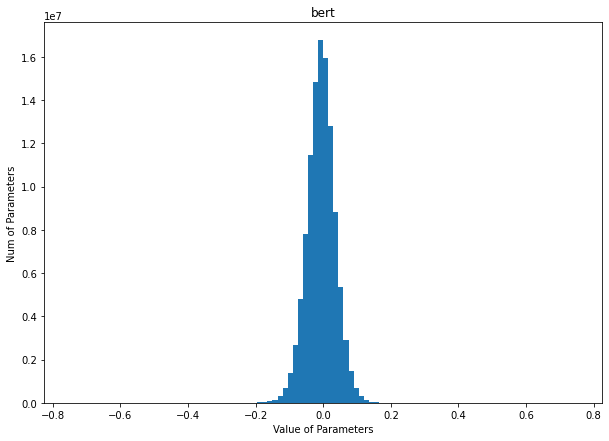

gpt-2
tensor([-0.1101, -0.0393,  0.0331,  ..., -0.0101, -0.0255,  0.0345],
       grad_fn=<CatBackward0>)


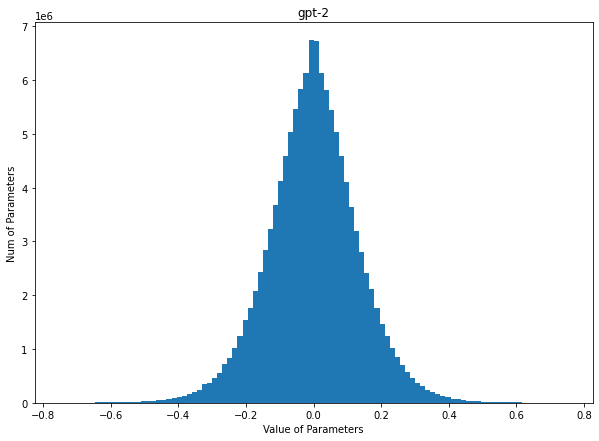

bart
tensor([ 0.0125,  0.0014, -0.0096,  ..., -0.1119, -0.2028, -0.0818],
       grad_fn=<CatBackward0>)


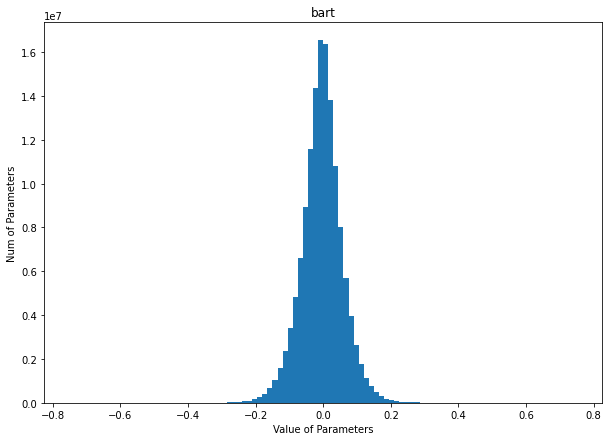

In [ ]:
import matplotlib.pyplot as plt

for key in models.keys():
  parameter_total = []
  model = models[key][0]
  print(key)
  for parameter in model.parameters():
    if parameter.requires_grad:
      parameter = parameter.flatten()
      parameter_total.append(parameter)

  parameter_total = torch.cat(parameter_total)
  print(parameter_total)
  parameter_total = parameter_total.detach().numpy()
  fig, axs = plt.subplots(
                        figsize =(10, 7))
  plt.ylabel("Num of Parameters")
  plt.xlabel("Value of Parameters")
  plt.title(key)
  axs.hist(parameter_total, bins = 100, range=(-.75,.75))
  plt.savefig("/content/results/{}-num-dist.png".format(key))
 
# Show plot
  plt.show()

bert


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

KeyboardInterrupt: ignored

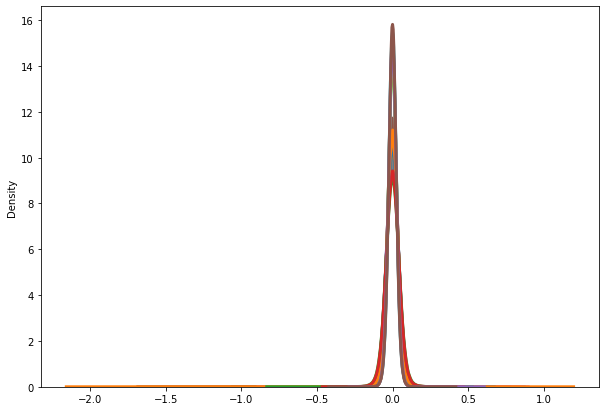

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
for key in models.keys():
  model = models[key][0]
  print(key)
  layer_count = 0
  fig, axs = plt.subplots(
                        figsize =(10, 7))
  for layer in model.modules():
    if not isinstance(layer, models[key][1]):
      continue
    parameter_total = []
    for parameter in layer.parameters():
      if parameter.requires_grad:
        parameter = parameter.flatten()
        parameter_total.append(parameter)

    parameter_total = torch.cat(parameter_total)
    parameter_total = parameter_total.detach().numpy()
    axs = sns.distplot(parameter_total, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},bins=100,
                 label = 'layer {}'.format(layer_count))
    
    layer_count += 1
  
  axs.set_xlim(-1, 1)
  plt.legend()
  plt.ylabel("Num of Parameters")
  plt.xlabel("Value of Parameters")
  plt.title(key)
  plt.savefig("/content/results/{}-layer-dist.png".format(key))
# Show plot
  plt.show()

Test pruned data

In [ ]:
# Check that we are using 100% of GPU
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip -q install gputil
!pip -q install psutil
!pip -q install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 84.5 GB  | Proc size: 14.9 GB
GPU RAM Free: 40536MB | Used: 0MB | Util   0% | Total 40536MB


In [ ]:
!mkdir -p plots_pt

In [ ]:
!python run_benchmark.py  --save_to_csv \
                                --inference_time_csv_file plots_pt/required_time_bart.csv \
                                --inference_memory_csv_file plots_pt/required_memory_bart.csv \
                                --env_info_csv_file plots_pt/env.csv \
                                --models /content/models/bart\
                                        /content/models/bart-0.1 \
                                        /content/models/bart-0.5 \
                                        /content/models/bart-0.5 \
                                        /content/models/bart-0.95\
                                        /content/models/bart-0.99\
                                --sequence_lengths 64 \
                                --batch_sizes 128

/usr/local/lib/python3.7/dist-packages/transformers/benchmark/benchmark_args_utils.py:140: FutureWarning: The class <class 'transformers.benchmark.benchmark_args.PyTorchBenchmarkArguments'> is deprecated. Hugging Face Benchmarking utils are deprecated in general and it is advised to use external Benchmarking libraries  to benchmark Transformer models.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/benchmark/benchmark_utils.py:619: FutureWarning: The class <class 'transformers.benchmark.benchmark.PyTorchBenchmark'> is deprecated. Hugging Face Benchmarking utils are deprecated in general and it is advised to use external Benchmarking libraries  to benchmark Transformer models.
  FutureWarning,
1 / 6
2 / 6
3 / 6
4 / 6
5 / 6
6 / 6

====================       INFERENCE - SPEED - RESULT       ====================
--------------------------------------------------------------------------------
          Model Name             Batch Size     Seq Length     Time in s   
--

In [ ]:
!python run_benchmark.py  --save_to_csv \
                                --inference_time_csv_file plots_pt/required_time_bart.csv \
                                --inference_memory_csv_file plots_pt/required_memory_bart.csv \
                                --env_info_csv_file plots_pt/env.csv \
                                --models /content/models/bart\
                                        /content/models/bart-0.1 \
                                        /content/models/bart-0.5 \
                                        /content/models/bart-0.5 \
                                        /content/models/bart-0.95\
                                        /content/models/bart-0.99\
                                --sequence_lengths 64 \
                                --batch_sizes 128

In [ ]:
!python run_benchmark.py  --save_to_csv \
                                --inference_time_csv_file plots_pt/required_time_bert.csv \
                                --inference_memory_csv_file plots_pt/required_memory_bert.csv \
                                --env_info_csv_file plots_pt/env.csv \
                                --models /content/models/bert\
                                        /content/models/bart-0.1 \
                                        /content/models/bert-0.5 \
                                        /content/models/bert-0.5 \
                                        /content/models/bert-0.95\
                                        /content/models/bert-0.99\
                                --sequence_lengths 64 \
                                --batch_sizes 128

/usr/local/lib/python3.7/dist-packages/transformers/benchmark/benchmark_args_utils.py:140: FutureWarning: The class <class 'transformers.benchmark.benchmark_args.PyTorchBenchmarkArguments'> is deprecated. Hugging Face Benchmarking utils are deprecated in general and it is advised to use external Benchmarking libraries  to benchmark Transformer models.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/benchmark/benchmark_utils.py:619: FutureWarning: The class <class 'transformers.benchmark.benchmark.PyTorchBenchmark'> is deprecated. Hugging Face Benchmarking utils are deprecated in general and it is advised to use external Benchmarking libraries  to benchmark Transformer models.
  FutureWarning,
1 / 6
2 / 6
3 / 6
4 / 6
5 / 6
6 / 6

====================       INFERENCE - SPEED - RESULT       ====================
--------------------------------------------------------------------------------
          Model Name             Batch Size     Seq Length     Time in s   
--

In [ ]:
!python run_benchmark.py  --save_to_csv \
                                --inference_time_csv_file plots_pt/required_time_gpt-2.csv \
                                --inference_memory_csv_file plots_pt/required_memory_gpt-2.csv \
                                --env_info_csv_file plots_pt/env.csv \
                                --models /content/models/gpt2\
                                        /content/models/gpt-2-0.1 \
                                        /content/models/gpt-2-0.5 \
                                        /content/models/gpt-2-0.5 \
                                        /content/models/gpt-2-0.95\
                                        /content/models/gpt-2-0.99\
                                --sequence_lengths 64 \
                                --batch_sizes 128

/usr/local/lib/python3.7/dist-packages/transformers/benchmark/benchmark_args_utils.py:140: FutureWarning: The class <class 'transformers.benchmark.benchmark_args.PyTorchBenchmarkArguments'> is deprecated. Hugging Face Benchmarking utils are deprecated in general and it is advised to use external Benchmarking libraries  to benchmark Transformer models.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/benchmark/benchmark_utils.py:619: FutureWarning: The class <class 'transformers.benchmark.benchmark.PyTorchBenchmark'> is deprecated. Hugging Face Benchmarking utils are deprecated in general and it is advised to use external Benchmarking libraries  to benchmark Transformer models.
  FutureWarning,
1 / 6
2 / 6
3 / 6
4 / 6
5 / 6
6 / 6

====================       INFERENCE - SPEED - RESULT       ====================
--------------------------------------------------------------------------------
          Model Name             Batch Size     Seq Length     Time in s   
--

Perplexity

In [ ]:
!python run_clm.py \
    --model_name_or_path /content/models/bart\
    --tokenizer_name "facebook/bart-base" \
    --dataset_name wikitext \
    --dataset_config_name wikitext-2-raw-v1 \
    --per_device_train_batch_size 8 \
    --per_device_eval_batch_size 8 \
    --do_train \
    --do_eval \
    --output_dir /content/test-clm/bart

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:
!python run_mlm.py \
    --model_name_or_path /content/models/bert\
    --tokenizer_name "bert-base-uncased" \
    --dataset_name wikitext \
    --dataset_config_name wikitext-2-raw-v1 \
    --per_device_train_batch_size 16 \
    --per_device_eval_batch_size 8 \
    --do_train \
    --do_eval \
    --output_dir /content/test-mlm/bert

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:
!python run_clm.py \
    --model_name_or_path /content/models/gpt2\
    --tokenizer_name "gpt2" \
    --dataset_name wikitext \
    --dataset_config_name wikitext-2-raw-v1 \
    --per_device_train_batch_size 8 \
    --per_device_eval_batch_size 8 \
    --do_train \
    --do_eval \
    --output_dir /content/test-clm/gpt2

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:
!python run_clm.py \
    --model_name_or_path /content/models/bart-0.1\
    --tokenizer_name "facebook/bart-base" \
    --dataset_name wikitext \
    --dataset_config_name wikitext-2-raw-v1 \
    --per_device_train_batch_size 8 \
    --per_device_eval_batch_size 8 \
    --do_train \
    --do_eval \
    --output_dir /content/test-clm/bart-0.1

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:
!python run_clm.py \
    --model_name_or_path /content/models/bart-0.5\
    --tokenizer_name "facebook/bart-base" \
    --dataset_name wikitext \
    --dataset_config_name wikitext-2-raw-v1 \
    --per_device_train_batch_size 8 \
    --per_device_eval_batch_size 8 \
    --do_train \
    --do_eval \
    --output_dir /content/test-clm/bart-0.5

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:
!python run_clm.py \
    --model_name_or_path /content/models/bart-0.9\
    --tokenizer_name "facebook/bart-base" \
    --dataset_name wikitext \
    --dataset_config_name wikitext-2-raw-v1 \
    --per_device_train_batch_size 8 \
    --per_device_eval_batch_size 8 \
    --do_train \
    --do_eval \
    --output_dir /content/test-clm/bart-0.9

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:
!python run_clm.py \
    --model_name_or_path /content/models/bart-0.95\
    --tokenizer_name "facebook/bart-base" \
    --dataset_name wikitext \
    --dataset_config_name wikitext-2-raw-v1 \
    --per_device_train_batch_size 8 \
    --per_device_eval_batch_size 8 \
    --do_train \
    --do_eval \
    --output_dir /content/test-clm/bart-0.95

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:

!python run_clm.py \
    --model_name_or_path /content/models/bart-0.99\
    --tokenizer_name "facebook/bart-base" \
    --dataset_name wikitext \
    --dataset_config_name wikitext-2-raw-v1 \
    --per_device_train_batch_size 6 \
    --per_device_eval_batch_size 6 \
    --do_train \
    --do_eval \
    --output_dir /content/test-clm/bart-0.99

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:
!python run_mlm.py \
    --model_name_or_path /content/models/bert-0.1\
    --tokenizer_name "bert-base-uncased" \
    --dataset_name wikitext \
    --dataset_config_name wikitext-2-raw-v1 \
    --per_device_train_batch_size 8 \
    --per_device_eval_batch_size 8 \
    --do_train \
    --do_eval \
    --output_dir /content/test-mlm/bert-0.1


INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:

!python run_mlm.py \
    --model_name_or_path /content/models/bert-0.5\
    --tokenizer_name "bert-base-uncased" \
    --dataset_name wikitext \
    --dataset_config_name wikitext-2-raw-v1 \
    --per_device_train_batch_size 16 \
    --per_device_eval_batch_size 8 \
    --do_train \
    --do_eval \
    --output_dir /content/test-mlm/new/bert-0.5

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:
!python run_mlm.py \
    --model_name_or_path /content/models/bert-0.9\
    --tokenizer_name "bert-base-uncased" \
    --dataset_name wikitext \
    --dataset_config_name wikitext-2-raw-v1 \
    --per_device_train_batch_size 8 \
    --per_device_eval_batch_size 8 \
    --do_train \
    --do_eval \
    --output_dir /content/test-mlm/bert-0.9

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:

!python run_mlm.py \
    --model_name_or_path /content/models/bert-0.95\
    --tokenizer_name "bert-base-uncased" \
    --dataset_name wikitext \
    --dataset_config_name wikitext-2-raw-v1 \
    --per_device_train_batch_size 16 \
    --per_device_eval_batch_size 8 \
    --do_train \
    --do_eval \
    --output_dir /content/test-mlm/bert-0.95

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:
!python run_mlm.py \
    --model_name_or_path /content/models/bert-0.99\
    --tokenizer_name "bert-base-uncased" \
    --dataset_name wikitext \
    --dataset_config_name wikitext-2-raw-v1 \
    --per_device_train_batch_size 16 \
    --per_device_eval_batch_size 8 \
    --do_train \
    --do_eval \
    --output_dir /content/test-mlm/bert-0.99

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:

!python run_clm.py \
    --model_name_or_path /content/models/gpt-2-0.1\
    --tokenizer_name "gpt2" \
    --dataset_name wikitext \
    --dataset_config_name wikitext-2-raw-v1 \
    --per_device_train_batch_size 8 \
    --per_device_eval_batch_size 8 \
    --do_train \
    --do_eval \
    --output_dir /content/test-clm/gpt-2-0.1

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:
!python run_clm.py \
    --model_name_or_path /content/models/gpt-2-0.5\
    --tokenizer_name "gpt2" \
    --dataset_name wikitext \
    --dataset_config_name wikitext-2-raw-v1 \
    --per_device_train_batch_size 8 \
    --per_device_eval_batch_size 8 \
    --do_train \
    --do_eval \
    --output_dir /content/test-clm/gpt-2-0.5

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:
!python run_clm.py \
    --model_name_or_path /content/models/gpt-2-0.9\
    --tokenizer_name "gpt2" \
    --dataset_name wikitext \
    --dataset_config_name wikitext-2-raw-v1 \
    --per_device_train_batch_size 8 \
    --per_device_eval_batch_size 8 \
    --do_train \
    --do_eval \
    --output_dir /content/test-clm/gpt-2-0.9

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:

!python run_clm.py \
    --model_name_or_path /content/models/gpt-2-0.95\
    --tokenizer_name "gpt2" \
    --dataset_name wikitext \
    --dataset_config_name wikitext-2-raw-v1 \
    --per_device_train_batch_size 8 \
    --per_device_eval_batch_size 8 \
    --do_train \
    --do_eval \
    --output_dir /content/test-clm/gpt-2-0.95


In [ ]:


!python run_clm.py \
    --model_name_or_path /content/models/gpt-2-0.99\
    --tokenizer_name "gpt2" \
    --dataset_name wikitext \
    --dataset_config_name wikitext-2-raw-v1 \
    --per_device_train_batch_size 8 \
    --per_device_eval_batch_size 8\
    --do_train \
    --do_eval \
    --output_dir /content/test-clm/gpt-2-0.99


INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

Text classification

In [ ]:
# get codes from huggingface
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/pytorch/text-classification/run_glue.py

--2022-11-09 05:57:19--  https://raw.githubusercontent.com/huggingface/transformers/master/examples/pytorch/text-classification/run_glue.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27264 (27K) [text/plain]
Saving to: ‘run_glue.py’

run_glue.py         100%[===================>]  26.62K  --.-KB/s    in 0s      

2022-11-09 05:57:19 (130 MB/s) - ‘run_glue.py’ saved [27264/27264]

--2022-11-09 05:57:19--  https://raw.githubusercontent.com/huggingface/transformers/master/examples/pytorch/text-classification/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP reque

In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 4.1 MB/s 
     |████████████████████████████████| 441 kB 45.6 MB/s 
     |████████████████████████████████| 1.3 MB 68.3 MB/s 
     |████████████████████████████████| 72 kB 1.6 MB/s 
     |████████████████████████████████| 212 kB 76.2 MB/s 
     |████████████████████████████████| 115 kB 84.4 MB/s 
     |████████████████████████████████| 95 kB 5.3 MB/s 
     |████████████████████████████████| 127 kB 75.3 MB/s 
     |████████████████████████████████| 115 kB 53.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6


In [ ]:


!python run_glue.py \
  --model_name_or_path /content/models/bart \
  --tokenizer_name "facebook/bart-base" \
  --task_name mrpc \
  --do_train \
  --do_eval \
  --max_seq_length 128 \
  --per_device_train_batch_size 64 \
  --learning_rate 2e-5 \
  --num_train_epochs 3 \
  --output_dir tmp/bart/

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:
!python run_glue.py \
  --model_name_or_path /content/models/bart-0.1 \
  --tokenizer_name "facebook/bart-base" \
  --task_name mrpc \
  --do_train \
  --do_eval \
  --max_seq_length 128 \
  --per_device_train_batch_size 64 \
  --learning_rate 2e-5 \
  --num_train_epochs 3 \
  --output_dir tmp/bart-0.1/


INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:

!python run_glue.py \
  --model_name_or_path /content/models/bart-0.5 \
  --tokenizer_name "facebook/bart-base" \
  --task_name mrpc \
  --do_train \
  --do_eval \
  --max_seq_length 128 \
  --per_device_train_batch_size 64 \
  --learning_rate 2e-5 \
  --num_train_epochs 3 \
  --output_dir tmp/bart-0.5/


INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:

!python run_glue.py \
  --model_name_or_path /content/models/bart-0.9 \
  --tokenizer_name "facebook/bart-base" \
  --task_name mrpc \
  --do_train \
  --do_eval \
  --max_seq_length 128 \
  --per_device_train_batch_size 64 \
  --learning_rate 2e-5 \
  --num_train_epochs 3 \
  --output_dir tmp/bart-0.9/

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:


!python run_glue.py \
  --model_name_or_path /content/models/bart-0.95 \
  --tokenizer_name "facebook/bart-base" \
  --task_name mrpc \
  --do_train \
  --do_eval \
  --max_seq_length 128 \
  --per_device_train_batch_size 64 \
  --learning_rate 2e-5 \
  --num_train_epochs 3 \
  --output_dir tmp/bart-0.95/

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:
!python run_glue.py \
  --model_name_or_path /content/models/bart-0.99 \
  --tokenizer_name "facebook/bart-base" \
  --task_name mrpc \
  --do_train \
  --do_eval \
  --max_seq_length 128 \
  --per_device_train_batch_size 64 \
  --learning_rate 2e-5 \
  --num_train_epochs 3 \
  --output_dir tmp/bart-0.99/

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:
!python run_glue.py \
  --model_name_or_path /content/models/bert \
  --tokenizer_name "bert-base-uncased" \
  --task_name mrpc \
  --do_train \
  --do_eval \
  --max_seq_length 128 \
  --per_device_train_batch_size 64 \
  --learning_rate 2e-5 \
  --num_train_epochs 3 \
  --output_dir tmp/bert/

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:
!python run_glue.py \
  --model_name_or_path /content/models/bert-0.1 \
  --tokenizer_name "bert-base-uncased" \
  --task_name mrpc \
  --do_train \
  --do_eval \
  --max_seq_length 128 \
  --per_device_train_batch_size 64 \
  --learning_rate 2e-5 \
  --num_train_epochs 3 \
  --output_dir tmp/bert-0.1/

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:
!python run_glue.py \
  --model_name_or_path /content/models/bert-0.5 \
  --tokenizer_name "bert-base-uncased" \
  --task_name mrpc \
  --do_train \
  --do_eval \
  --max_seq_length 128 \
  --per_device_train_batch_size 32 \
  --learning_rate 2e-5 \
  --num_train_epochs 3 \
  --output_dir tmp/bert-0.5/


INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:
!python run_glue.py \
  --model_name_or_path /content/models/bert-0.9 \
  --tokenizer_name "bert-base-uncased" \
  --task_name mrpc \
  --do_train \
  --do_eval \
  --max_seq_length 128 \
  --per_device_train_batch_size 128 \
  --learning_rate 2e-5 \
  --num_train_epochs 3 \
  --output_dir tmp/bert-0.9/

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:


!python run_glue.py \
  --model_name_or_path /content/models/bert-0.95 \
  --tokenizer_name "bert-base-uncased" \
  --task_name mrpc \
  --do_train \
  --do_eval \
  --max_seq_length 128 \
  --per_device_train_batch_size 32 \
  --learning_rate 2e-5 \
  --num_train_epochs 3 \
  --output_dir tmp/bert-0.95/

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:
!python run_glue.py \
  --model_name_or_path /content/models/bert-0.99 \
  --tokenizer_name "bert-base-uncased" \
  --task_name mrpc \
  --do_train \
  --do_eval \
  --max_seq_length 128 \
  --per_device_train_batch_size 32 \
  --learning_rate 2e-5 \
  --num_train_epochs 3 \
  --output_dir tmp/bert-0.99/

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:
!python run_glue.py \
  --model_name_or_path /content/models/gpt2 \
  --tokenizer_name /content/models/gpt2-tokenizer \
  --task_name mrpc \
  --do_train \
  --do_eval \
  --max_seq_length 128 \
  --per_device_train_batch_size 32 \
  --learning_rate 2e-5 \
  --num_train_epochs 3 \
  --output_dir tmp/gpt2/

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:
#50257
!python run_glue.py \
  --model_name_or_path /content/models/gpt-2-0.1 \
  --tokenizer_name /content/models/gpt2-tokenizer \
  --task_name mrpc \
  --do_train \
  --do_eval \
  --max_seq_length 128 \
  --per_device_train_batch_size 32 \
  --learning_rate 2e-5 \
  --num_train_epochs 3 \
  --output_dir tmp/gpt-2-0.1/

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:

!python run_glue.py \
  --model_name_or_path /content/models/gpt-2-0.5 \
  --tokenizer_name /content/models/gpt2-tokenizer \
  --task_name mrpc \
  --do_train \
  --do_eval \
  --max_seq_length 128 \
  --per_device_train_batch_size 32 \
  --learning_rate 2e-5 \
  --num_train_epochs 3 \
  --output_dir tmp/gpt-2-0.5/

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:

!python run_glue.py \
  --model_name_or_path /content/models/gpt-2-0.9 \
  --tokenizer_name /content/models/gpt2-tokenizer \
  --task_name mrpc \
  --do_train \
  --do_eval \
  --max_seq_length 128 \
  --per_device_train_batch_size 32 \
  --learning_rate 2e-5 \
  --num_train_epochs 3 \
  --output_dir tmp/gpt-2-0.9/

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:

!python run_glue.py \
  --model_name_or_path /content/models/gpt-2-0.95 \
  --tokenizer_name /content/models/gpt2-tokenizer \
  --task_name mrpc \
  --do_train \
  --do_eval \
  --max_seq_length 128 \
  --per_device_train_batch_size 32 \
  --learning_rate 2e-5 \
  --num_train_epochs 3 \
  --output_dir tmp/gpt-2-0.95/

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me

In [ ]:

!python run_glue.py \
  --model_name_or_path /content/models/gpt-2-0.99 \
  --tokenizer_name /content/models/gpt2-tokenizer \
  --task_name mrpc \
  --do_train \
  --do_eval \
  --max_seq_length 128 \
  --per_device_train_batch_size 32 \
  --learning_rate 2e-5 \
  --num_train_epochs 3 \
  --output_dir tmp/gpt-2-0.99/

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_me